In [11]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import os
import os.path as osp
from tqdm import tqdm
import shutil 
import sys
import argparse
import pickle
from collections import OrderedDict

from utils import *
from models import *

import matplotlib.pyplot as plt

In [12]:
gpu_id='0'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  0


## load model

In [13]:
def select_model(model_name):
    if model_name=='deeponet':
        return deeponet
    elif model_name=='shiftdeeponet':
        return shiftdeeponet
    elif model_name=='flexdeeponet':
        return flexdeeponet
    elif model_name=='NOMAD':
        return NOMAD
    elif model_name=='hyperdeeponet':
        return hyperdeeponet

In [14]:
def load_model(model, state_dict):
    if args.multgpu:
        new_keys = []
        for key in state_dict.keys():
            new_key = key[7:]    # remove the 'module.'
            new_keys.append(new_key)
        new_values = OrderedDict(list(zip(new_keys, state_dict.values())))
        model.load_state_dict(new_values)
        print('multi gpu model is loaded')
    else:
        model.load_state_dict(state_dict)
        print('single gpu model is loaded')
    return model

In [15]:
#name = 'SIRv4_int_11_hyperdeepoent_rec'
#name = 'SIRv4_int_11_hyperdeepoent'

name = 'SIRv5_int_11_hyperdeepoent_rec'

In [16]:
path=os.path.join('results',name)
args=torch.load(os.path.join(path,'args.bin'))
state_dict=torch.load(os.path.join(path,'weight.bin'))
loss_dict=torch.load(os.path.join(path,'loss.bin'))
model_name = 'small '+args.model if 'small' in name else args.model
args

Namespace(a_hyper='tanh', a_target='tanh', batch=20000, d_hyper=2, d_in=1, d_out=3, d_target=2, data='SIR_v5_rec', epochs=20000, gamma=0.0001, gpu_idx=0, load_path=None, lr=0.001, model='hyperdeeponet', multgpu=False, n_basis=10, n_sensor=121, name='SIRv5_int_11_hyperdeepoent_rec', sche_type='inversetime', seed=1, step_size=1, w_hyper=20, w_target=20, wd=0.0)

In [17]:
model=select_model(args.model)(
                args.d_target,
                args.w_target,
                args.a_target,
                args.d_hyper,
                args.w_hyper,
                args.a_hyper,    
                args.n_sensor,
                args.d_in,
                args.n_basis,
                args.d_out
            ).cuda()
model = load_model(model, state_dict)

single gpu model is loaded


In [18]:
for k,v in model.named_parameters():
    v.requires_grad=False

# for k,v in model.named_parameters():
#     print(k,v)
#     break

In [19]:
# for k,v in model.named_parameters():
#     print(k,v)
#     break

## phase 2

In [20]:
N = 1000
T = 30
M = args.n_sensor # sensor 개수
D = np.linspace(0, T, M)
interp = 11 # 31
num_iter = 20000

data_name=args.data+'_N'+str(N)+'_M'+str(M)+'_int'+str(interp)+'.pickle'

with open(os.path.join("data_generation",data_name),"rb") as fr:
    load_data= pickle.load(fr)
    print(data_name, 'is loaded')

if 'T' not in load_data:
    load_data['T'] = 1
if 'S0' not in load_data:
    load_data['S0'] = 1
if 'I0' not in load_data:
    load_data['I0'] = 1

In [22]:
def viz(iteration, sensor_u):
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
    with torch.no_grad():
        pred=model(test_x[:,M:],test_x[:,:M]).detach().cpu()
    
    pred[:,0] = pred[:,0]*load_data['S0']
    pred[:,1] = pred[:,1]*load_data['I0']
    
    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 1)  
    #plt.plot(xnew, ynew,'--',color='gray')
    plt.plot(D, sensor_u.detach().cpu().numpy(), 'o',color='red',markersize=3)
    plt.xlabel('t')
    plt.title('[iter : %d] u(t)'%iteration)

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 2)  
    #plt.plot(D, y[:,0],label='ode solver',markersize=3)
    plt.plot(D, pred[:,0],'--',markersize=3)
    plt.title('[iter : %d] S(t)'%iteration)
    plt.xlabel('t')

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 3)  
    #plt.plot(D, y[:,1],label='ode solver',markersize=3)
    plt.plot(D, pred[:,1],'--',markersize=3)
    plt.title('[iter : %d] I(t)'%iteration)
    plt.xlabel('t')
    plt.show()

    # print('res S :',rel_L2_error(pred[:,0],y[:,0]).item())
    # print('res I :',rel_L2_error(pred[:,1],y[:,1]).item())


In [77]:
#c1,c2,c3 = 1e-6,1e-3,1
c1,c2,c3 = 1,10,100
sensor_D = torch.tensor(D/load_data['T']).float().cuda()


#torch.manual_seed(42)
#sensor_u = torch.rand(M).cuda()

#idx=np.random.randint(0,200)
#sensor_u=load_data['train_X'][M*idx][:M].float().cuda()
#sensor_u=load_data['test_X'][M*idx][:M].float().cuda()


torch.manual_seed(42)
sensor_u = torch.tensor([0.5]*M).cuda()


rec = True
alpha = 1e-6
clamp = True
lr = 1e-3

## check init ##
#viz(0,sensor_u)

  0%|                                                                                        | 0/20001 [00:00<?, ?it/s]

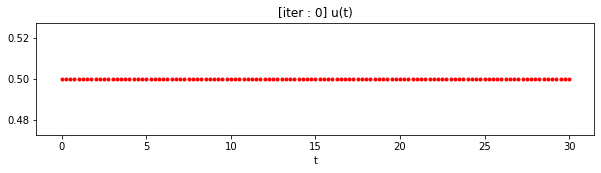

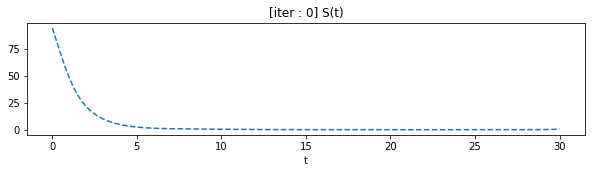

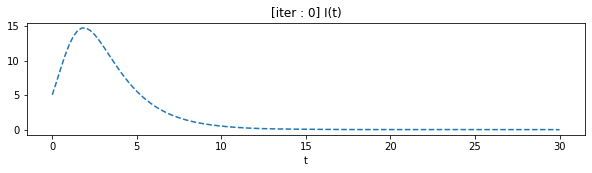

[iter : 999]:   5%|███                                                            | 983/20001 [00:01<00:57, 332.26it/s]

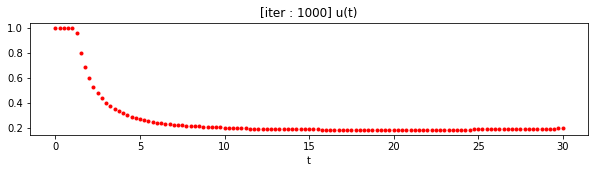

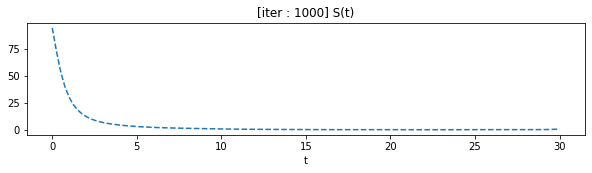

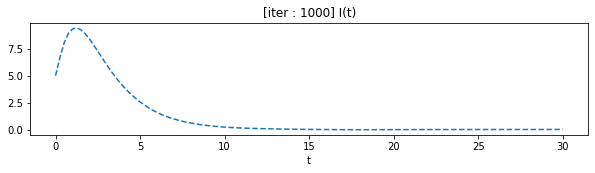

[iter : 1999]:  10%|█████▉                                                       | 1955/20001 [00:03<00:29, 609.13it/s]

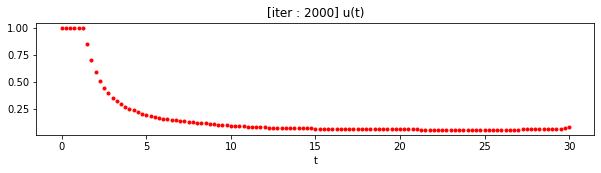

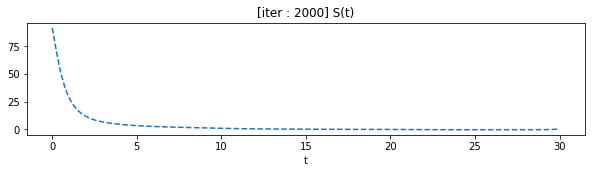

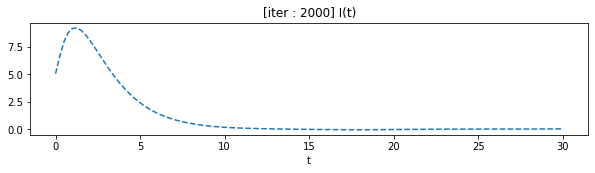

[iter : 2999]:  15%|█████████▏                                                   | 2998/20001 [00:05<00:26, 638.34it/s]

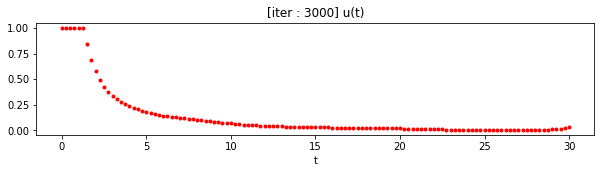

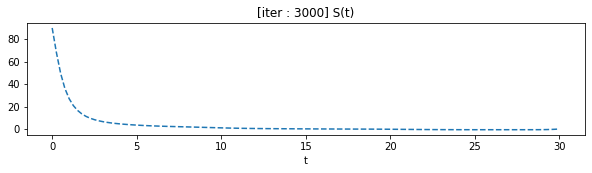

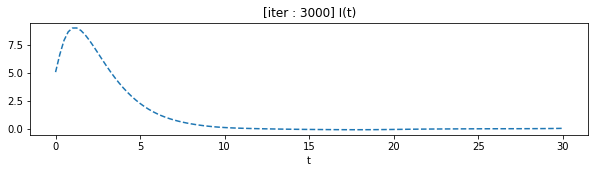

[iter : 3999]:  20%|████████████                                                 | 3939/20001 [00:07<00:24, 652.75it/s]

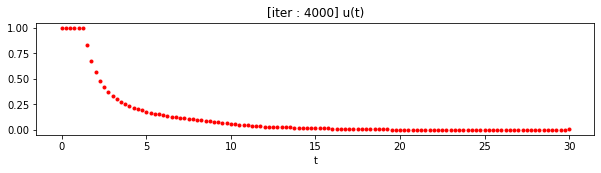

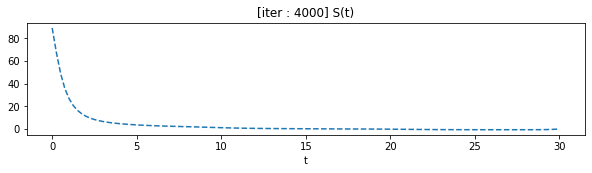

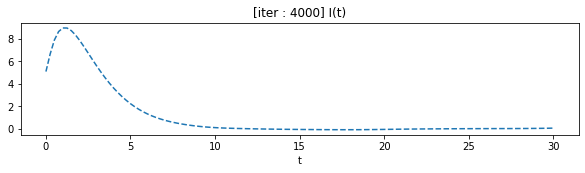

[iter : 4999]:  25%|███████████████▏                                             | 4990/20001 [00:09<00:23, 649.42it/s]

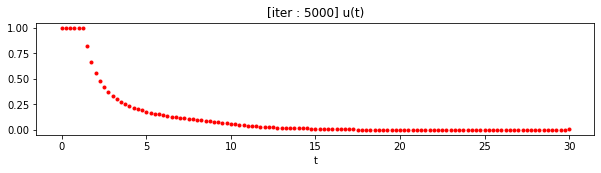

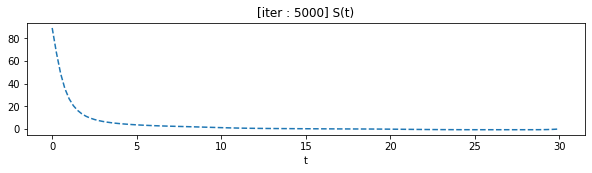

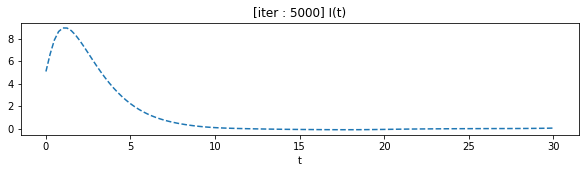

[iter : 5999]:  30%|██████████████████▏                                          | 5975/20001 [00:11<00:21, 644.03it/s]

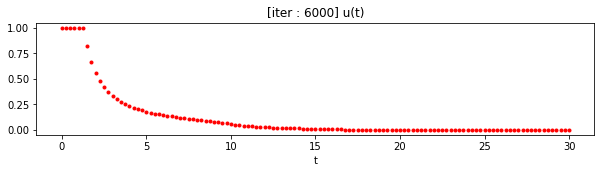

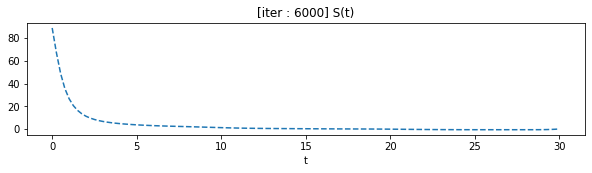

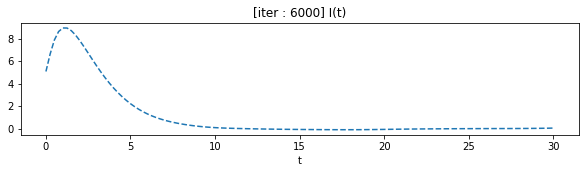

[iter : 6999]:  35%|█████████████████████▎                                       | 6981/20001 [00:13<00:20, 635.00it/s]

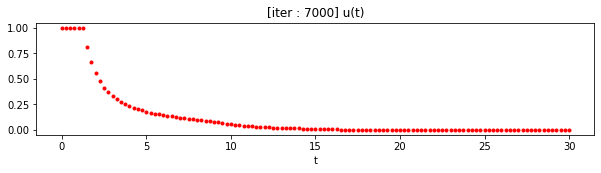

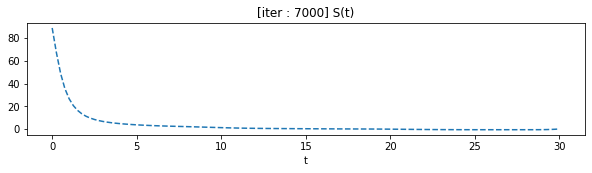

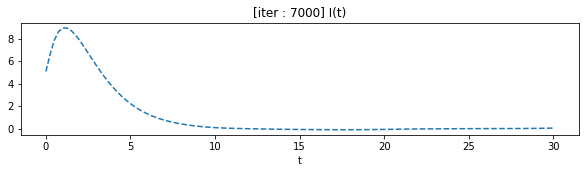

[iter : 7999]:  40%|████████████████████████▎                                    | 7966/20001 [00:15<00:19, 616.03it/s]

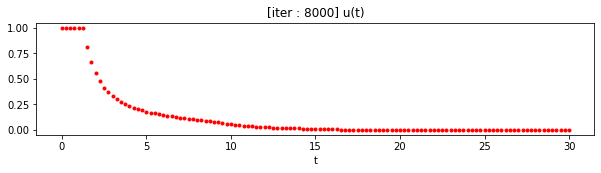

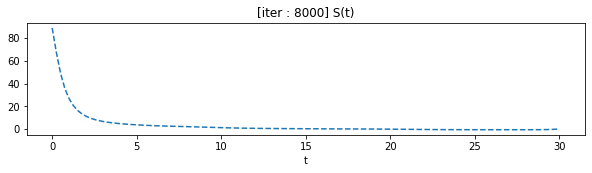

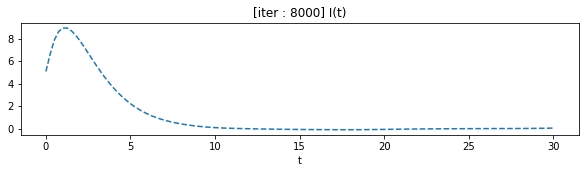

[iter : 8999]:  45%|███████████████████████████▎                                 | 8949/20001 [00:16<00:17, 634.51it/s]

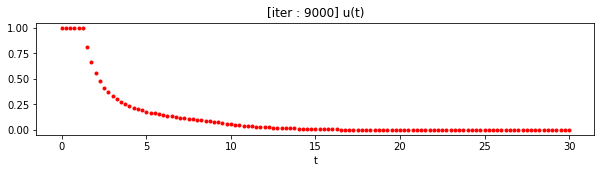

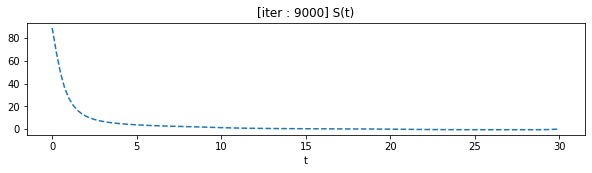

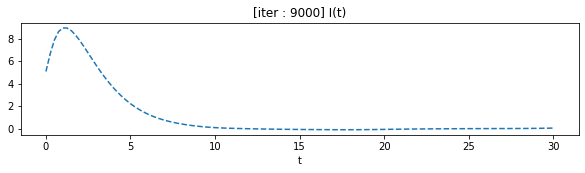

[iter : 9999]:  50%|██████████████████████████████▍                              | 9975/20001 [00:18<00:15, 633.18it/s]

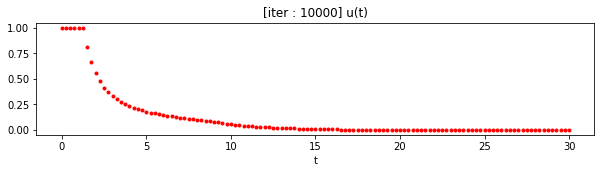

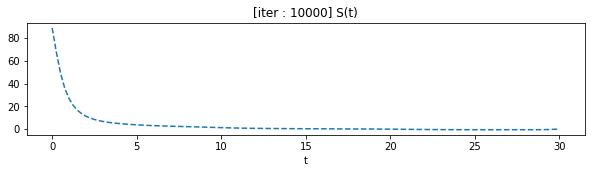

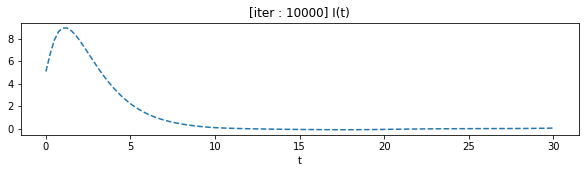

[iter : 10999]:  55%|████████████████████████████████▎                          | 10942/20001 [00:20<00:14, 640.36it/s]

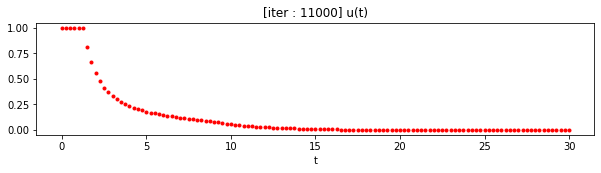

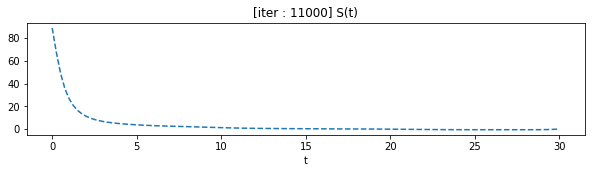

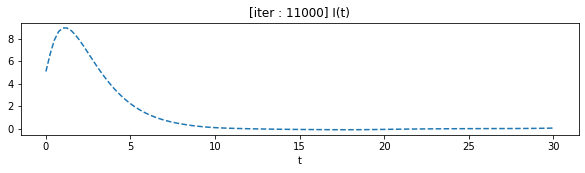

[iter : 11999]:  60%|███████████████████████████████████▏                       | 11941/20001 [00:22<00:12, 630.09it/s]

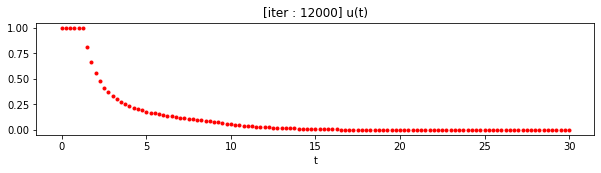

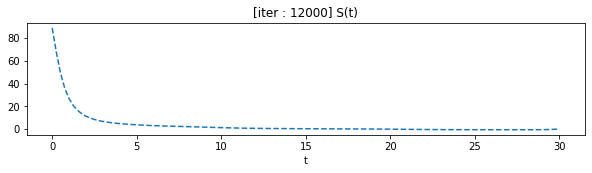

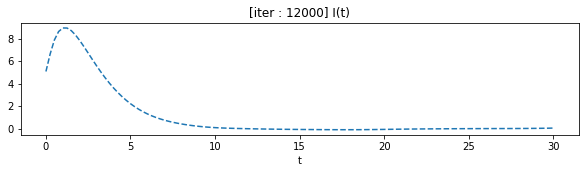

[iter : 12999]:  65%|██████████████████████████████████████▏                    | 12949/20001 [00:24<00:11, 611.05it/s]

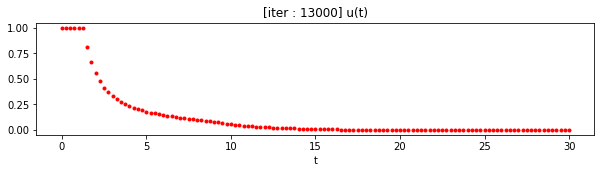

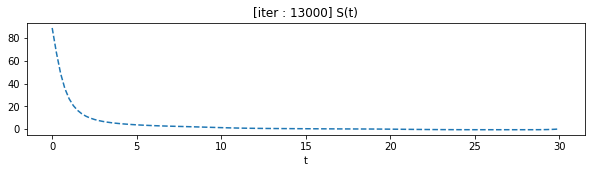

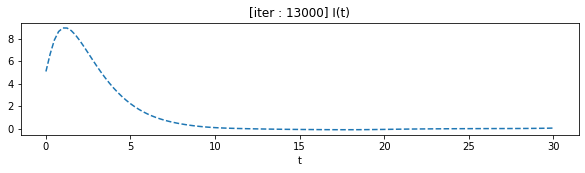

[iter : 13999]:  70%|█████████████████████████████████████████▏                 | 13980/20001 [00:26<00:09, 632.92it/s]

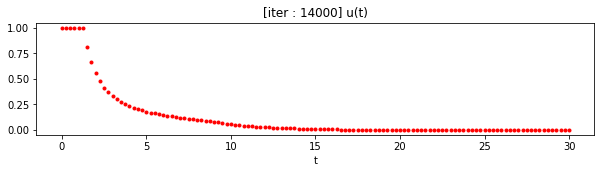

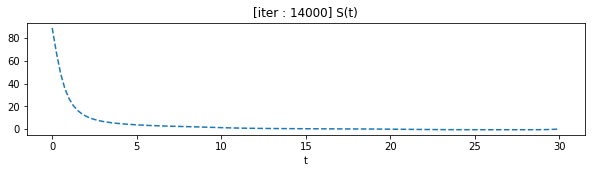

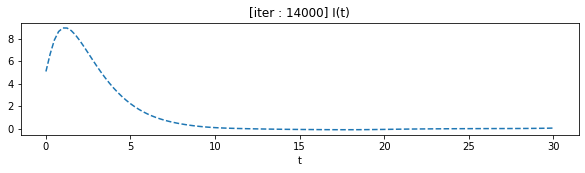

[iter : 14999]:  75%|████████████████████████████████████████████               | 14940/20001 [00:28<00:08, 627.92it/s]

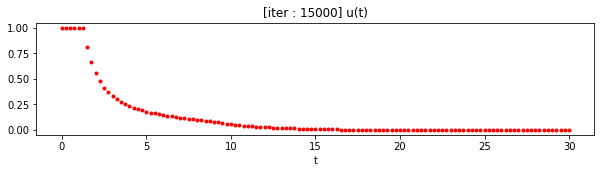

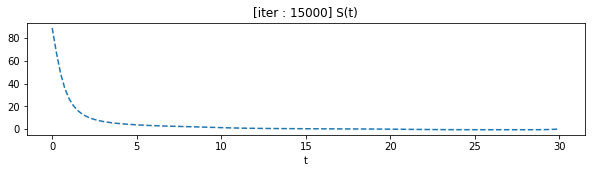

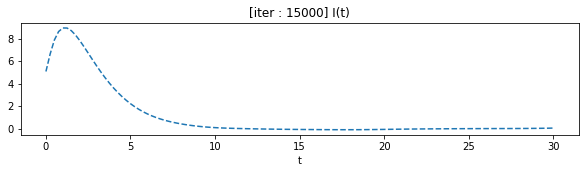

[iter : 15999]:  80%|███████████████████████████████████████████████            | 15968/20001 [00:30<00:06, 639.97it/s]

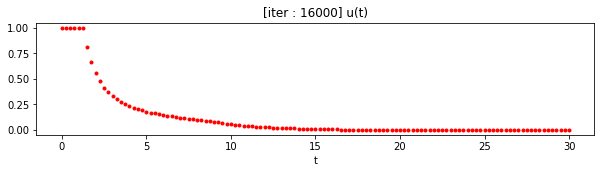

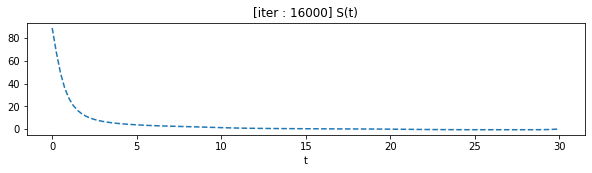

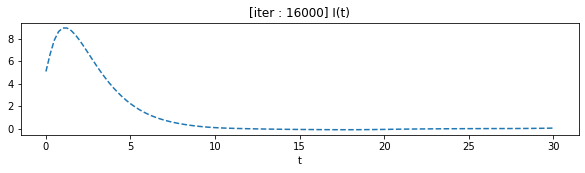

[iter : 16999]:  85%|█████████████████████████████████████████████████▉         | 16937/20001 [00:32<00:04, 649.64it/s]

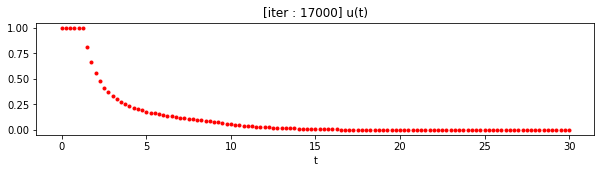

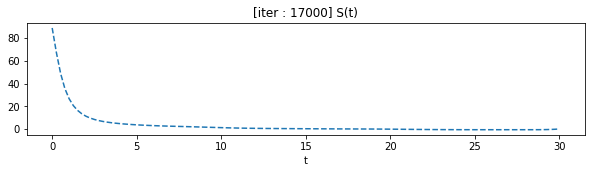

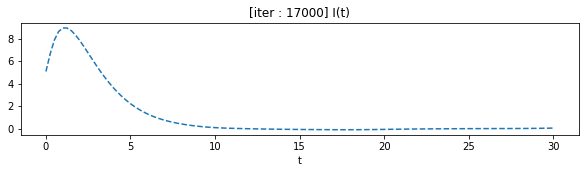

[iter : 17999]:  90%|█████████████████████████████████████████████████████      | 17994/20001 [00:33<00:03, 648.50it/s]

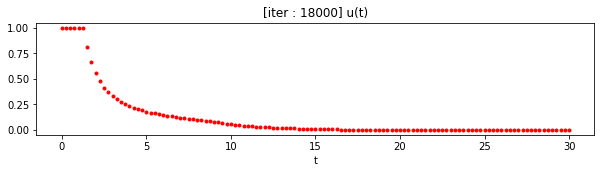

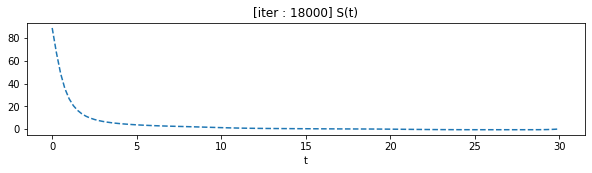

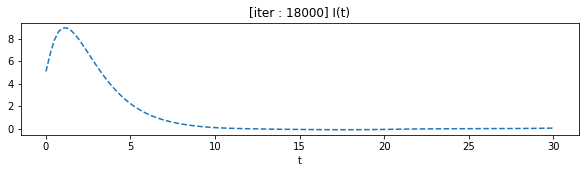

[iter : 18999]:  95%|███████████████████████████████████████████████████████▉   | 18969/20001 [00:35<00:01, 636.06it/s]

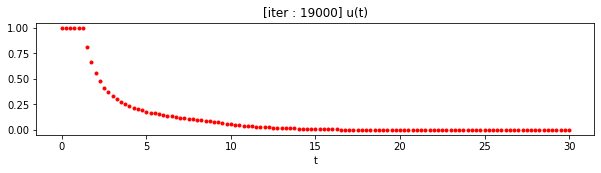

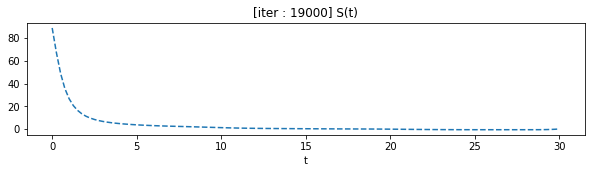

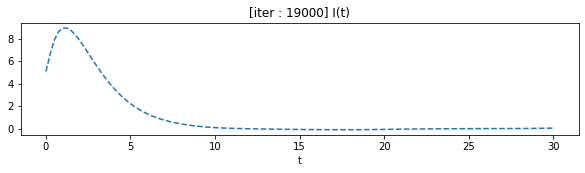

[iter : 19999]: 100%|██████████████████████████████████████████████████████████▊| 19938/20001 [00:37<00:00, 626.83it/s]

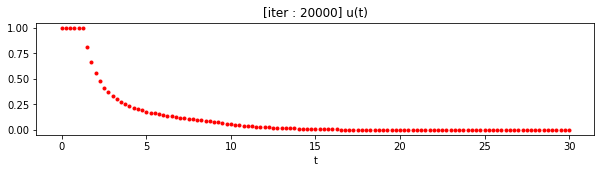

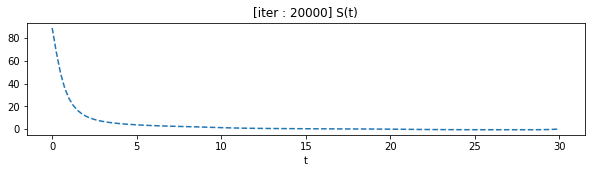

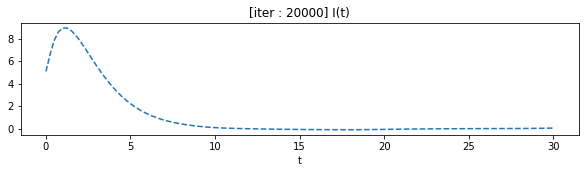

[iter : 20000]: 100%|███████████████████████████████████████████████████████████| 20001/20001 [00:38<00:00, 525.32it/s]


In [78]:
#
#u = PolynomialModel(degree).cuda()
#u = LinearModel([5,5,5]).cuda()
#optimizer=torch.optim.Adam(u.parameters(), lr=lr, weight_decay=w_decay)

## for viz ##
#xnew = np.linspace(0, T, 10*M)
#Dnew = torch.tensor(xnew).float().cuda()
###

model.eval()
pbar = tqdm(range(num_iter+1),position=0, leave=True,file=sys.stdout)
losses = []
result = {}
loss = 0
for iteration in pbar: 
    if iteration % 1000 == 0:
        viz(iteration,sensor_u)
        result[iteration] = sensor_u.detach().cpu().numpy()
        plt.show()
        
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

    # test_x = []
    # for j in D:
    #     test_x.append(np.append(sensor_u, j))
    # test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()
    
    pred=model(test_x[:,M:],test_x[:,:M])

    sensor_s = pred[:,0]*load_data['S0']
    sensor_i = pred[:,1]*load_data['I0']
    
    # wrong ver #
    #sensor_u = sensor_u - lr*(c2*sensor_s+2*c3*sensor_u)
    
    # correct ver #
    sensor_u -= lr*(sensor_u-(c2*sensor_s)/(2*c3)) 
    
    
    # rec #
    if rec:
        rec_u = pred[:,2]
        sensor_u -= lr*alpha*(sensor_u-(rec_u)) 
    # clamp #
    if clamp:
        sensor_u = torch.clamp(sensor_u,0,1)
    
    pbar.set_description("[iter : %d]"%(iteration))
    #losses.append(loss.item())
    
    

cost functional value : tensor(986.8546, device='cuda:0')


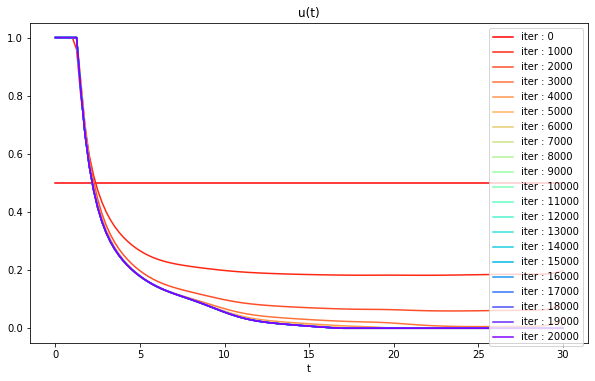

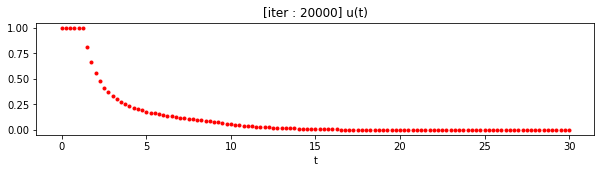

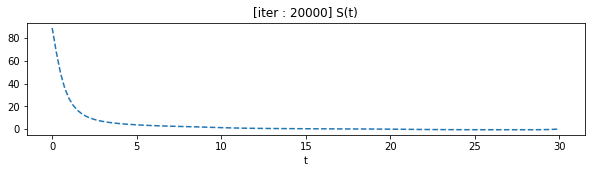

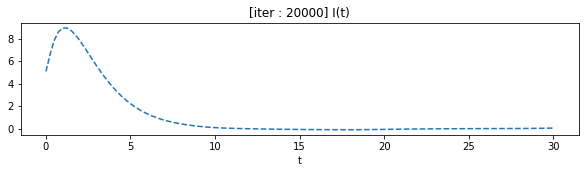

In [79]:
### final result ###
model.eval()
test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
pred=model(test_x[:,M:],test_x[:,:M])
sensor_s = pred[:,0]*load_data['S0']
sensor_i = pred[:,1]*load_data['I0']
print('cost functional value :',torch.trapz(c1*sensor_i+c2*sensor_u*sensor_s+c3*sensor_u**2, sensor_D*load_data['T']))

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)  

colors = plt.cm.rainbow(np.linspace(1,0, len(result))) 
for i,(k,v) in enumerate(result.items()):
    plt.plot(D, v,color=colors[i], label = 'iter : '+str(k))
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
#plt.title("u(t) {degree :%d}"%(degree))
plt.title("u(t)") 
plt.legend()

viz(num_iter,sensor_u)

Text(0.5, 1.0, 'u(t) (alpha : 0.001000)')

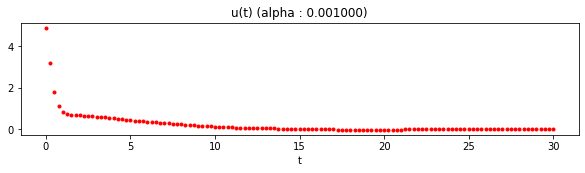

In [43]:
test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
with torch.no_grad():
    pred=model(test_x[:,M:],test_x[:,:M]).detach().cpu()

pred[:,0] = pred[:,0]*load_data['S0']
pred[:,1] = pred[:,1]*load_data['I0']

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)  
#plt.plot(xnew, ynew,'--',color='gray')
plt.plot(D, sensor_u.detach().cpu().numpy(), 'o',color='red',markersize=3)
plt.xlabel('t')
plt.title("u(t) (alpha : %f)"%(alpha))

- 여러번 실험

In [44]:
def main(sensor_u, c1, c2, c3, visualize=False):
    model.eval()
    pbar = tqdm(range(num_iter+1),position=0, leave=True,file=sys.stdout)
    losses = []
    result = {}
    loss = 0
    for iteration in pbar: 
        if iteration % 1000 == 0:
            if visualize:
                viz(iteration,sensor_u)
            result[iteration] = sensor_u.detach().cpu().numpy()
            plt.show()

        test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

        # test_x = []
        # for j in D:
        #     test_x.append(np.append(sensor_u, j))
        # test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()

        pred=model(test_x[:,M:],test_x[:,:M])

        sensor_s = pred[:,0]*load_data['S0']
        sensor_i = pred[:,1]*load_data['I0']

        sensor_u = sensor_u - lr*(c2*sensor_s+2*c3*sensor_u)
        #sensor_u = sensor_u - lr*(sensor_u-(c2*sensor_s)/(2*c3)) 

        ###
        #sensor_u = -(c2*sensor_s)/(2*c3) 
        #sensor_u = sensor_u - lr*(-(c2*sensor_s)/(2*c3))

        pbar.set_description("[iter : %d]"%(iteration))

    ### viz train result ###
    plt.figure(figsize=(10,20))
    plt.subplot(3, 1, 1)  

    colors = plt.cm.rainbow(np.linspace(1,0, len(result))) 
    for i,(k,v) in enumerate(result.items()):
        plt.plot(D, v,color=colors[i], label = 'iter : '+str(k))
    #plt.plot(D, x, 'o',color='red',markersize=3)
    plt.xlabel('t')
    #plt.ylim(0,1)
    #plt.title("u(t) {degree :%d}"%(degree))
    plt.title("u(t) (c2 = %.6f)"%(c2))
    plt.legend()

    viz(num_iter,sensor_u)

[iter : 20000]: 100%|███████████████████████████████████████████████████████████| 20001/20001 [00:39<00:00, 511.95it/s]


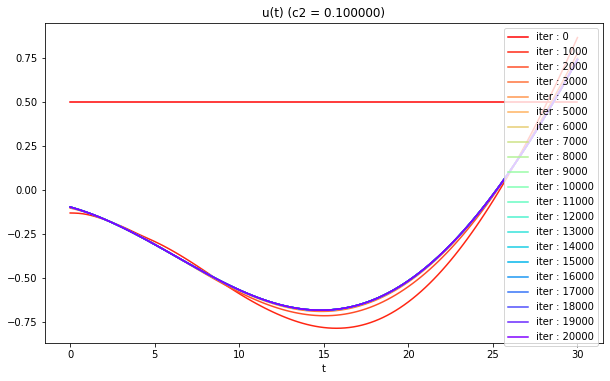

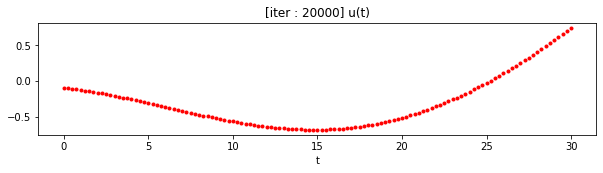

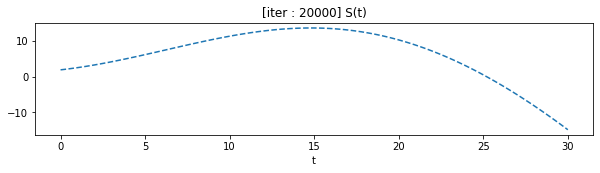

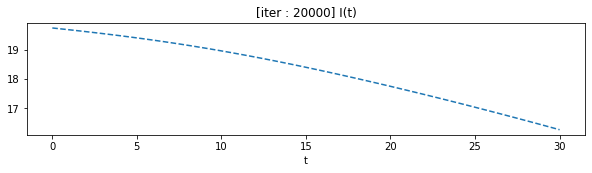

[iter : 20000]: 100%|███████████████████████████████████████████████████████████| 20001/20001 [00:38<00:00, 525.97it/s]


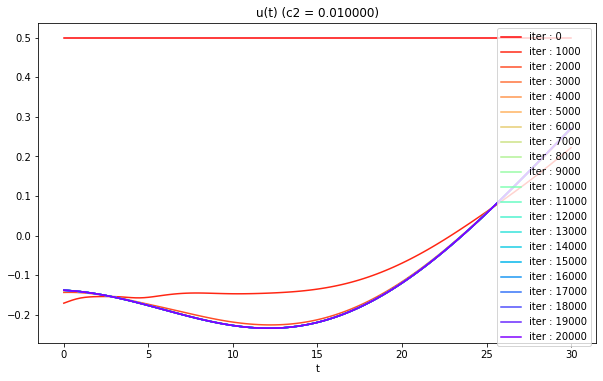

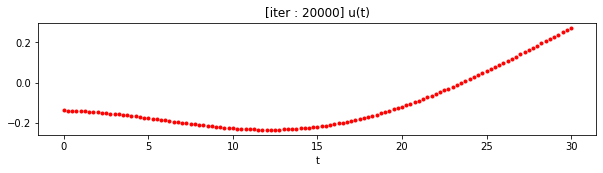

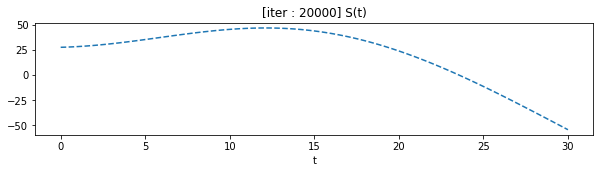

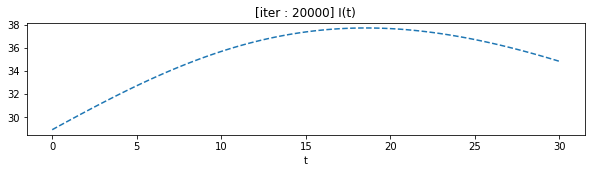

[iter : 20000]: 100%|███████████████████████████████████████████████████████████| 20001/20001 [00:38<00:00, 513.80it/s]


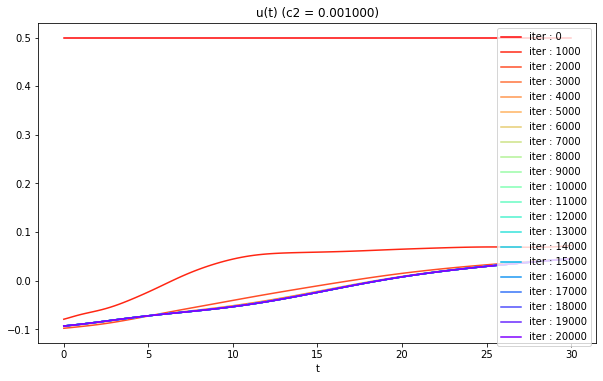

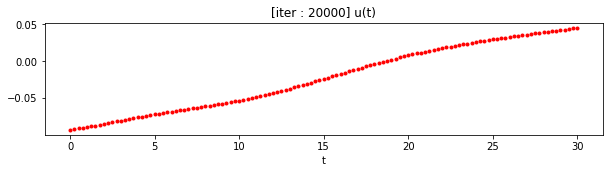

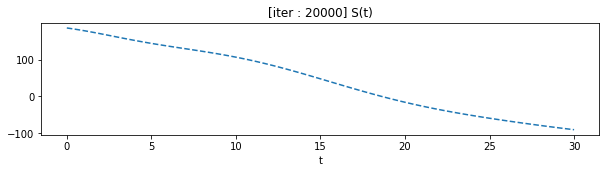

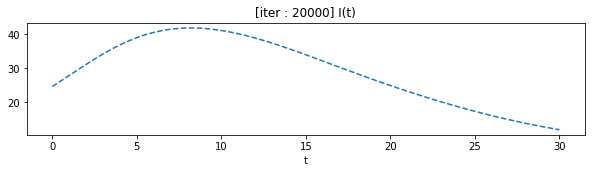

[iter : 20000]: 100%|███████████████████████████████████████████████████████████| 20001/20001 [00:38<00:00, 520.83it/s]


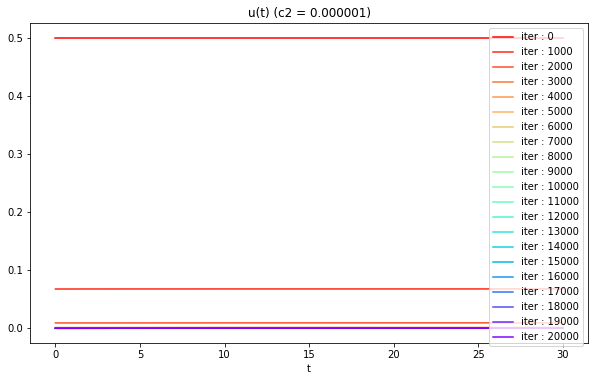

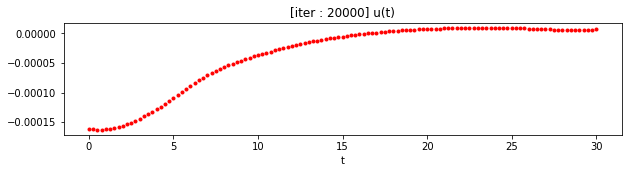

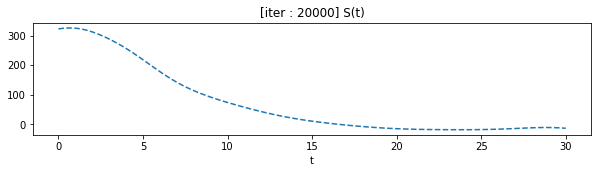

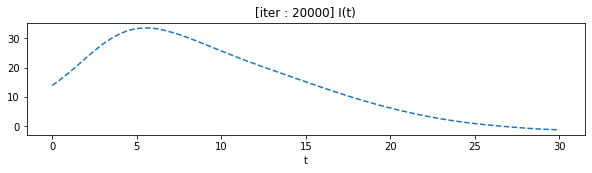

In [45]:
for c2 in [1e-1,1e-2,1e-3,1e-6]:
    torch.manual_seed(42)
    sensor_u = torch.tensor([0.5]*M).cuda()
    main(sensor_u=sensor_u, c1=1e-6, c2=c2, c3=1)

# 잘못된 ver

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, layer_dims, act = 'relu'):
        super().__init__()
        if act == 'relu':
            self.act = nn.ReLU()
        self.block = lambda d_in,d_out : nn.Sequential(nn.Linear(d_in, d_out),self.act)
        layer_dims = [1]+layer_dims
        layer = []
        for i in range(len(layer_dims)-1):
            layer.append(self.block(layer_dims[i],layer_dims[i+1]))
        layer.append(nn.Linear(layer_dims[-1],1))
        self.layer = nn.Sequential(*layer)
    def forward(self, x):
        x = self.layer(x.view(-1,1)).view(-1)
        return torch.clamp(x,min=0,max=1)

In [ ]:
class PolynomialModel(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self._degree = degree
        self.linear = nn.Linear(self._degree, 1)
        init.constant_(self.linear.weight, 0)
        init.constant_(self.linear.bias, 1)

    def forward(self, x):
        x = self.linear(self._polynomial_features(x))
        #return x
        return torch.clamp(x,min=0,max=1) # x
        

    def _polynomial_features(self, x):
        x = x.unsqueeze(1)
        return torch.cat([x ** i for i in range(1, self._degree + 1)], 1)

In [ ]:
T = 30
M = args.n_sensor # sensor 개수
D = np.linspace(0, T, M)
c1 = 1e-6
c2 = 1e-6
c3 = 1

lr = 1e-4
w_decay = 0
num_iter = 20000
degree = 10

In [ ]:
sensor_D = torch.tensor(D).float().cuda()
#u = PolynomialModel(degree).cuda()
u = LinearModel([5,5,5]).cuda()
optimizer=torch.optim.Adam(u.parameters(), lr=lr, weight_decay=w_decay)

## for viz ##
xnew = np.linspace(0, T, 10*M)
Dnew = torch.tensor(xnew).float().cuda()
###

model.eval()
pbar = tqdm(range(num_iter+1),position=0, leave=True,file=sys.stdout)
losses = []
result = {}
loss = 0
for iteration in pbar: 
    if iteration % 1000 == 0:
        u.eval()
        with torch.no_grad():
            pred = u(Dnew).view(-1).cpu().numpy()
        plt.figure(figsize=(10,7))
        plt.subplot(3, 1, 1)  
        plt.plot(xnew, pred)
        plt.xlabel('t')
        plt.ylim(0,1.1)
        plt.title("u(t) (iter : %d, loss : %f)"%(iteration,loss))
        result[iteration] = pred
        plt.show()
        
    u.train()
    sensor_u = u(sensor_D).squeeze(-1)
    # sensor_u = torch.arange(10)
    # sensor_D = torch.arange(M)
    # torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

    # test_x = []
    # for j in D:
    #     test_x.append(np.append(sensor_u, j))
    # test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()

    pred=model(test_x[:,M:],test_x[:,:M])

    sensor_s = pred[:,0]
    sensor_i = pred[:,1]

    #dJ_du = c2*sensor_s+ 2*c3*sensor_u
    loss = torch.trapz(c1*sensor_i+c2*sensor_u*sensor_s+c3*sensor_u**2, sensor_D)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description("[iter : %d] loss : %f"%(iteration,loss))
    losses.append(loss.item())
    
    

In [ ]:
## 1개 viz ##
u.eval()
xnew = np.linspace(0, T, 10*M)
Dnew = torch.tensor(xnew).float().cuda() # for viz
with torch.no_grad():
    pred = u(Dnew).view(-1).cpu().numpy()

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)  
plt.plot(xnew, pred,color='gray')
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
plt.title('u(t)')

## visualize

In [ ]:
plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)  

colors = plt.cm.rainbow(np.linspace(1,0, len(result))) 
for i,(k,v) in enumerate(result.items()):
    plt.plot(xnew, v,color=colors[i], label = 'iter : '+str(k))
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
#plt.title("u(t) {degree :%d}"%(degree))
plt.title("u(t) (u_0(t) = 1)")
plt.legend()